In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA # functional
using ImageTransformations
using Statistics
# using Interpolations
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

KnetArray{Float32, N} where N

In [2]:
function resize_gray_image_tensor(im_tensor, ratio = 1, method = BSpline(Interpolations.Linear()))
    im_tensor_copy = copy(im_tensor)
    im_new_size = Int.((size(im_tensor))[1:2] .* ratio)
    im_tensor = zeros(im_new_size[1],im_new_size[2], size(im_tensor, 3))
    
    for i in (1:size(im_tensor,3))
        img = im_tensor_copy[:,:,i]
        img_resized = Array{Float32}(imresize(Matrix{Gray{Float32}}(img), ratio = ratio, method = method ))
        im_tensor[:,:,i] = img_resized
    end
    im_tensor_copy = nothing
    return im_tensor
end

function resize_MNIST(im_tensor, ratio = 1, method = BSpline(Interpolations.Linear()))
    im_tensor_copy = copy(im_tensor)
    im_new_size = Int.((size(im_tensor))[1:2] .* ratio)
    im_tensor = zeros(im_new_size[1],im_new_size[2], size(im_tensor, 3))
    
    for i in (1:size(im_tensor,3))
        img = im_tensor_copy[:,:,i]
        img_resized = Array{Float32}(imresize(Matrix{Gray{Float32}}(img'), ratio = ratio, method = method ))
        im_tensor[:,:,i] = img_resized
    end
    im_tensor_copy = nothing
    return im_tensor
end

resize_MNIST (generic function with 3 methods)

In [3]:
xtrn,_ = MNIST.traindata()
xtst,_ = MNIST.testdata()
xtrn = Array{Float64, 3}(xtrn)
xtst = Array{Float64, 3}(xtst)

xtrn = resize_MNIST(xtrn, 32/28)
xtst = resize_MNIST(xtst, 32/28)

dtrn = minibatch(xtrn, 100; xsize = (32*32,:), xtype = array_type)
dtst = minibatch(xtst, 100; xsize = (32*32,:), xtype = array_type);

In [4]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)

# Fully-Connected Layer Definition
struct FC; w; b; f; end
FC(i::Int,o::Int,f=relu) = FC(param(o,i),param0(o),f)
(l::FC)(x) = l.f.(l.w * x .+ l.b)

# Simple Encoder and Decoder Definitions
latent_dim = 32
Encoder = Chain(FC(32*32, 128), FC(128, 64), FC(64,latent_dim))
Decoder = Chain(FC(latent_dim, 64), FC(64, 128), FC(128, 32*32, sigm))

# Model Definition
struct Model; E::Chain; D::Chain; end
Model(Encoder, Decoder) = Model(Encoder, Decoder)
(M:: Model)(x) = M.D(M.E(x))

# Batch Loss and General Loss Definition (Reconstruction Error := Mean Squared Error)

loss(m::Model,x) = sum((x - m(x)).^2) / size(x,4)

function loss(m::Model, d::Data)
    total_loss = 0
    n_instance = 0
   for x in d
        total_loss += loss(m, x) * size(x,4)
        n_instance += size(x,4)
    end
    
    total_loss /= n_instance
end

inner_loss(m::Model, x) = mean(((m(x) - x).^2))

function inner_loss(m::Model,d::Data)
    total_loss = 0
    n_instance = 0
   for x in d
        total_loss += inner_loss(m, x) * size(x,2)
        n_instance += size(x,2)
    end
    
    total_loss /= n_instance
end

inner_loss (generic function with 2 methods)

In [5]:
function train_model(m, L, dtrn, n_epochs, lr, verbose = true, watch_tst_loss = false, dtst = nothing)
    batch_loss_list = Float64[]
    loss_list = Float64[]
    tst_loss_list = Float64[]
    
    if verbose
        for epoch in (1:n_epochs)
            for x in progress(dtrn )
                x_rec = m(x)
                push!(batch_loss_list, L(m,x))
                derivative = @diff L(m,x)
                for p in params(m)
                     dp = grad(derivative, p)
                     update!(value(p), dp, Knet.Adam(lr = lr,beta1 = 0.9, beta2 = 0.999))
                end
            end
            push!(loss_list, L(m, dtrn))

            last_loss = loss_list[end]

            
            if watch_tst_loss
                if dtst == nothing
                    print("Epoch: $epoch, Train Loss: $last_loss")
                else
                    last_tst_loss = L(m, dtst)
                    push!(tst_loss_list, last_tst_loss)
                    print("Epoch: $epoch, Train Loss: $last_loss, Test Loss: $last_tst_loss")
                end
            end
            
        end
        
    else
        for epoch in progress(1:n_epochs)
            for x in dtrn 
                x_rec = m(x)
                push!(batch_loss_list, L(m,x))
                derivative = @diff L(m,x)
                    for p in params(m)
                         dp = grad(derivative, p)
                         update!(value(p), dp, Knet.Adam(lr = lr,beta1 = 0.9, beta2 = 0.999))
                    end
            end
            push!(loss_list, L(m, dtrn))

            last_loss = loss_list[end]
            if watch_tst_loss
                if dtst == nothing
                    continue
                else
                    push!(tst_loss_list, L(m, dtst))
                end
            end
        end

    end
    return batch_loss_list, loss_list, tst_loss_list
end

train_model (generic function with 4 methods)

In [6]:
m = Model(Encoder, Decoder)
b_list, l_list, tst_l_list = train_model(m, inner_loss, dtrn, 15, 1e-4, true, true, dtst);

┣████████████████████┫ [100.00%, 600/600, 00:30/00:30, 19.82i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2031.19i/s] 

Epoch: 1, Train Loss: 0.04857560247182846, Test Loss: 0.04872757

┣████████████████████┫ [100.00%, 600/600, 00:02/00:02, 247.25i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2512.70i/s] 

Epoch: 2, Train Loss: 0.03505222871899605, Test Loss: 0.034933332

┣████████████████████┫ [100.00%, 600/600, 00:02/00:02, 279.18i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2693.19i/s] 

Epoch: 3, Train Loss: 0.030111581087112427, Test Loss: 0.029915525

┣████████████████████┫ [100.00%, 600/600, 00:02/00:02, 276.34i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2532.46i/s] 

Epoch: 4, Train Loss: 0.02617616206407547, Test Loss: 0.025946764

┣████████████████████┫ [100.00%, 600/600, 00:02/00:02, 251.55i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2520.68i/s] 

Epoch: 5, Train Loss: 0.023404231294989586, Test Loss: 0.023166383

┣████████████████████┫ [100.00%, 600/600, 00:02/00:02, 272.16i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2758.20i/s] 

Epoch: 6, Train Loss: 0.021611269563436508, Test Loss: 0.021375865

┣████████████████████┫ [100.00%, 600/600, 00:02/00:02, 279.35i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2629.40i/s] 

Epoch: 7, Train Loss: 0.02028905227780342, Test Loss: 0.020048127

┣████████████████████┫ [100.00%, 600/600, 00:02/00:02, 251.02i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2760.01i/s] 

Epoch: 8, Train Loss: 0.019077911972999573, Test Loss: 0.01881137

┣████████████████████┫ [100.00%, 600/600, 00:02/00:02, 255.76i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2954.44i/s] 

Epoch: 9, Train Loss: 0.018236752599477768, Test Loss: 0.017968418

┣████████████████████┫ [100.00%, 600/600, 00:02/00:02, 276.14i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2500.33i/s] 

Epoch: 10, Train Loss: 0.017537536099553108, Test Loss: 0.017270006

┣████████████████████┫ [100.00%, 600/600, 00:02/00:02, 262.45i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2592.58i/s] 

Epoch: 11, Train Loss: 0.017079276964068413, Test Loss: 0.016820017

┣████████████████████┫ [100.00%, 600/600, 00:02/00:02, 259.02i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2700.29i/s] 

Epoch: 12, Train Loss: 0.016682900488376617, Test Loss: 0.01642779

┣████████████████████┫ [100.00%, 600/600, 00:02/00:02, 287.33i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2020.14i/s] 

Epoch: 13, Train Loss: 0.016358360648155212, Test Loss: 0.016105833

┣████████████████████┫ [100.00%, 600/600, 00:02/00:02, 263.11i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2516.12i/s] 

Epoch: 14, Train Loss: 0.016073931008577347, Test Loss: 0.015824007

┣████████████████████┫ [100.00%, 600/600, 00:02/00:02, 272.00i/s] 


Epoch: 15, Train Loss: 0.015814699232578278, Test Loss: 0.015567605

In [7]:
function plot_reconstructed_images(im_ori, im_rec, n_instances = 10, plot_size = (900,300))
    k = rand(1:100, n_instances)
    ori_plot_list = reshape(im_ori[:,k[1]], (32, 32))
    recon_plot_list = reshape(im_rec[:,k[1]], (32, 32))
    for j in k[2:end]
        ori_plot_list = hcat(ori_plot_list, reshape(im_ori[:,j], (32, 32)))
        recon_plot_list = hcat(recon_plot_list, reshape(im_rec[:,j], (32, 32)))
    end
    p1 = plot(Matrix{Gray{Float32}}(ori_plot_list), title = "Original Images", size = (20,200),font =  "Courier", xtick = false, ytick = false)
    p2 = plot(Matrix{Gray{Float32}}(recon_plot_list), title = "Reconstructed Images", font = "Courier", xtick = false, ytick = false)
    plot(p1, p2, layout = (2,1), size = (900,300))
end

plot_reconstructed_images (generic function with 3 methods)

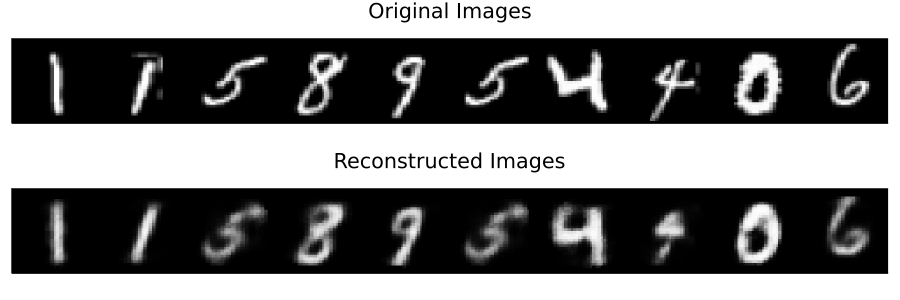

In [8]:
x = first(dtrn);

x_rec = m(x)

plot_reconstructed_images(x, x_rec)

In [9]:
function plot_loss_convergence(trn_loss, tst_loss = nothing, figsize = (700, 500), epochs = nothing)
    if epochs == nothing
         epochs = 1:size(trn_loss,1)
    end    
    if tst_loss != nothing
        if size(trn_loss,1) != size(tst_loss,1)
            print("The loss vectors for train and test do not have the same size")
            return 0
        else
            plot(epochs,l_list ,label = "Train Loss", xlabel = "Epochs", ylabel = "Loss",
            title = "Train Loss w.r.t. Epochs", minorgrid = true, xtickfontsize = 18,
            ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
            yguidefontsize=18, titlefontsize = 20, size = figsize)
            plot!(epochs,tst_l_list ,label = "Test Loss", title = "Train & Test Loss w.r.t. Epochs")
        end
    else
        plot(epochs,l_list ,label = "Train Loss", xlabel = "Epochs", ylabel = "Loss",
        title = "Train Loss w.r.t. Epochs", minorgrid = true, xtickfontsize = 18,
        ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
        yguidefontsize=18, titlefontsize = 20, size = figsize)
    end
    
end

plot_loss_convergence (generic function with 4 methods)

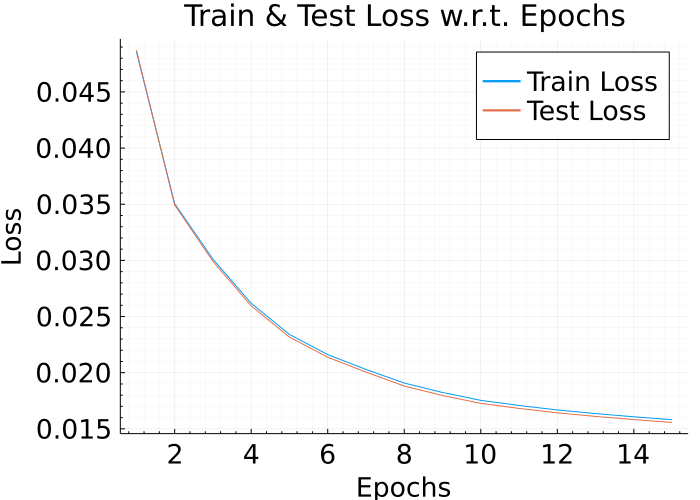

In [10]:
plot_loss_convergence(l_list, tst_l_list)